# Lets See if We Can Read the .Cube Files with Python Code From Scratch
Original email from Leif: 

Unfortunately, I do not. Maybe some psuedo-code might help.

The data itself is in unsigned short integers (2-byte/16-bits) in a format known as band interleaved by line. There is a 32768 byte header and if this is a cube from an SOC710VP, the cubes are 696 lines, by 520 samples by 128 bands.

After reading past the 32768 byte header, the loop for reading the data would be

```python
for(int x=0;x<696;x++)
      for(int b=0;b<128;b++)
            for(int y=0;y<520;y++)
                  pixel[x][y][b] = read(unsigned integer);
```

where x and y are the spatial dimensions and b is the band dimension.

I hope that helps.

Leif


# Step 1: Read in the .Cube File

In [53]:
# read past the 32768 byte header of the data in the format unsigned short integers (2-byte/16-bits)
import struct

header_size = 32768 # Size of the header in bytes
# data_file_path = "/Users/maycaj/Downloads/1 light 2.8-3 Calibrated.Cube "  
# data_file_path = "/Users/maycaj/Documents/Hyperspectral-Imaging/HyperspectralCameraFiles/Test 5.cube" # Replace with your data file path
data_file_path = '/Users/maycaj/Documents/Hyperspectral-Imaging_II/Lipstick_Sunscreen Images/Lipstick 2/Lipstick type 2 image 3.cube'
# Define the dimensions
num_lines = 696
num_samples = 520
num_bands = 128

# Create a 3D array to store the pixel data
pixel = [[[0 for _ in range(num_bands)] for _ in range(num_samples)] for _ in range(num_lines)] # dimensions of (696, 520, 128) 

pixel_test = pixel

# Open the .cube file
with open(data_file_path, 'rb') as file:
    # Skip the 32768 byte header
    file.seek(header_size, 0)
    
    # Loop through the data and read unsigned short integers
    for x in range(num_lines):
        for b in range(num_bands):
            for y in range(num_samples):
                # Read an unsigned short integer (2 bytes)
                data = file.read(2)
                if not data:
                    break
                pixel[x][y][b] = int.from_bytes(data, byteorder='little', signed=False)

# Now, the pixel array contains the data as described in your code.

In [54]:
# Sandbox cell
len(pixel_test), len(pixel_test[0]), len(pixel_test[0][0]), pixel_test[50][8][52]

(696, 520, 128, 198)

In [55]:
print('Lines',len(pixel))
print('Samples',len(pixel[0]))
print('Bands',len(pixel[0][0]))

Lines 696
Samples 520
Bands 128


# Step 2: Display the Image

np_pixel shape: (696, 520, 128)
Grey_bands shape: (696, 520, 1)
np_pixel_red shape: (696, 520)
np_pixel_color shape (696, 520, 3)


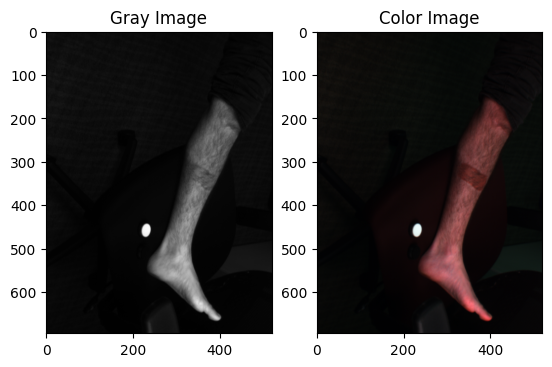

In [56]:
import matplotlib.pyplot as plt
import numpy as np

# Create a new figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2)

# Convert pixel to NP 
np_pixel = np.array(pixel)
print('np_pixel shape:', np_pixel.shape)

# Only display the 49th band in gray
np_pixel_grey = np_pixel[:, :, 49:50]
print('Grey_bands shape:', np_pixel_grey.shape)

# Display the gray image in the first subplot
ax1.imshow(np_pixel_grey, cmap='gray')
ax1.set_title('Gray Image')

# Grab the colored bands
np_pixel_red = np_pixel[:,:,20]
np_pixel_green = np_pixel[:,:,35]
np_pixel_blue = np_pixel[:,:,60]

# Normalize the bands to [0, 1] for each color channel
np_pixel_red = (np_pixel_red - np.min(np_pixel_red)) / (np.max(np_pixel_red) - np.min(np_pixel_red))
np_pixel_green = (np_pixel_green - np.min(np_pixel_green)) / (np.max(np_pixel_green) - np.min(np_pixel_green))
np_pixel_blue = (np_pixel_blue - np.min(np_pixel_blue)) / (np.max(np_pixel_blue) - np.min(np_pixel_blue))

print('np_pixel_red shape:', np_pixel_red.shape)

np_pixel_color = np.dstack((np_pixel_blue,np_pixel_green,np_pixel_red))
print('np_pixel_color shape',np_pixel_color.shape)

# Display the color image in the second subplot
ax2.imshow(np_pixel_color)
ax2.set_title('Color Image')

# Show the figure with both subplots
plt.show()

# Step 3: Save the Image file as .PNG and then use Preview to mask the image
- may need to change the save filepath

In [57]:
import numpy as np
from PIL import Image

# Assuming 'image_data' is your NumPy variable with shape (696, 520, 3)
# Replace 'image_data' with your actual variable name

# Create a PIL Image object from the NumPy array
image = Image.fromarray(np.uint8(np_pixel_color * 256))

# Save the image to a PNG file
image.save('/Users/maycaj/Documents/Hyperspectral-Imaging_II/CubeCropperOutput/output.png') # may need to change this filepath

print("Image saved as 'output.png'")


Image saved as 'output.png'


# Step 3.5: 
 * Open Preview
 * Use the lasso selection tool to select a region to cut out of image (Any part of image that is not exposed skin on leg)
 * **you must place a black square in the bottom right corner to preserve the original dimensions** – otherwise the code will not function properly 
 * Save the file and run next steps

# Step 4: Wherever the masked .PNG file is black Make the cube also be black

In [58]:
# Load the PNG image
image = Image.open('/Users/maycaj/Documents/Hyperspectral-Imaging_II/CubeCropperOutput/output.png')

# Convert the image to RGBA mode if it's not already
if image.mode != "RGBA":
    image = image.convert("RGBA")
    print('Image was converted to RGBA')

# Get the image data as a NumPy array
img_NP = image.load()

# Define the green color you want to use
green_color = (0, 255, 0, 255)  # RGBA format (R, G, B, A)

pixel_masked = np_pixel

# Iterate through the image pixels and change transparent ones to green
for x in range(image.width):
    for y in range(image.height):
        r, g, b, a = img_NP[x, y]
        if a == 0 or (r==0 and g==0 and b==0): #if cropped out or black
            img_NP[x, y] = green_color #change 
            # also change cube to black
            for band in range(pixel_masked.shape[2]): # Loop over each band
                pixel_masked[y][x][band] = 0

# Save the modified image
image.save('/Users/maycaj/Documents/Hyperspectral-Imaging_II/CubeCropperOutput/GreenOutput.png')

# Step 5: Display Pixel_masked to make sure we did it correctly

(696, 520, 128)
Grey_bands shape: (696, 520, 1)
masked_red shape: (696, 520)
np_pixel_color shape (696, 520, 3)


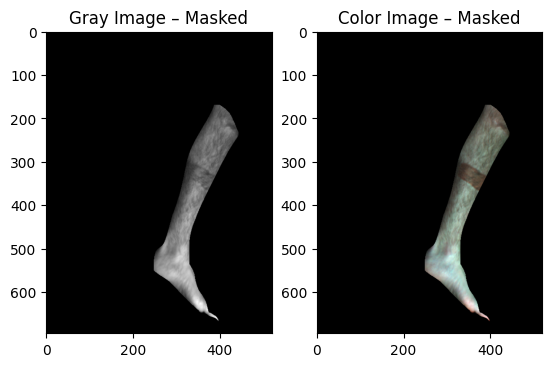

In [59]:
print(pixel_masked.shape)

# Create a new figure with two subplots
fig, (ax3, ax4) = plt.subplots(1, 2)

# Only display the 49th band in gray
pixel_masked = np_pixel[:, :, 49:50]
print('Grey_bands shape:', pixel_masked.shape)

# Display the gray image in the first subplot
ax3.imshow(pixel_masked, cmap='gray')
ax3.set_title('Gray Image – Masked')

# Grab the colored bands
masked_red = np_pixel[:,:,20]
masked_green = np_pixel[:,:,35]
masked_blue = np_pixel[:,:,60]

# Normalize the bands to [0, 1] for each color channel
masked_red = (masked_red - np.min(masked_red)) / (np.max(masked_red) - np.min(masked_red))
masked_green = (masked_green - np.min(masked_green)) / (np.max(masked_green) - np.min(masked_green))
masked_blue = (masked_blue - np.min(masked_blue)) / (np.max(masked_blue) - np.min(masked_blue))

print('masked_red shape:', masked_red.shape)

masked_color = np.dstack((masked_blue,masked_green,masked_red))
print('np_pixel_color shape',masked_color.shape)

# Display the color image in the second subplot
ax4.imshow(masked_color)
ax4.set_title('Color Image – Masked')

# Show the figure with both subplots
plt.show()

# Step 6: Explore the cropped data
Adjust the slider to the band you want to see

In [60]:
from ipywidgets import interact

def interactive_plot(band):
    # Create a new figure with two subplots
    fig, (ax5, ax4) = plt.subplots(1, 2)

    # Only display the 49th band in gray
    pixel_masked = np_pixel[:, :, band:(band + 1)]
    print('Grey_bands shape:', pixel_masked.shape)

    # Display the gray image in the first subplot
    ax5.imshow(pixel_masked, cmap='gray')
    ax5.set_title(f'Gray Image – Masked (band = {band})')

    # Display the color image in the second subplot
    ax4.imshow(masked_color)
    ax4.set_title('Color Image – Masked')

    # Show the figure with both subplots
    plt.show()

interact(interactive_plot, band=(0, 127, 1))

interactive(children=(IntSlider(value=63, description='band', max=127), Output()), _dom_classes=('widget-inter…

<function __main__.interactive_plot(band)>

# Step 7: Now Save the Cube as a .npy
So it can be easily loaded into a model

In [61]:
np.save('/Users/maycaj/Documents/Hyperspectral-Imaging_II/CubeCropperOutput/output.npy', np_pixel)

Now load the .npy file and view it

Text(0.5, 1.0, 'Gray Image –\xa0Masked')

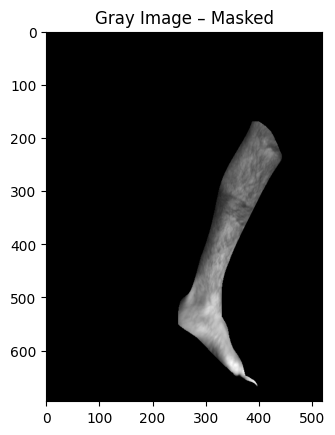

In [62]:
#Load the NPY file
pixel_loaded = np.load('/Users/maycaj/Documents/Hyperspectral-Imaging_II/CubeCropperOutput/output.npy')

# Display the NPY file
fig, ax = plt.subplots()
ax.imshow(pixel_loaded[:, :, 49:50], cmap='gray')
ax.set_title('Gray Image – Masked')

Now rename the output.npy file to the below filename

In [70]:
OutputName = data_file_path.split('/')[-1]
OutputName = OutputName.split('.')[0]
OutputName = OutputName + '.npy'
print(OutputName)

Lipstick type 2 image 3.npy
